Импортируем все необходимые библиотеки

In [ ]:
import pandas as pd
import math
import statsmodels.stats.api as sms
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro,levene,ttest_ind, mannwhitneyu
import scipy.stats as stats
import pylab

Загрузка и ознакомление с данными




In [ ]:
raw_data = pd.read_csv('/content/abtest.csv')
df = raw_data.copy()
df

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish
...,...,...,...,...,...,...
95,546446,treatment,new,5.15,no,Spanish
96,546544,control,old,6.52,yes,English
97,546472,treatment,new,7.07,yes,Spanish
98,546481,treatment,new,6.20,yes,Spanish


Разведочный анализ данных

Проверим правильно ли загрузились данные

In [ ]:
df.head()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish


In [ ]:
#получим информацию о количестве строк и столбцов
df.shape

In [ ]:
#проверим соответствие типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    object 
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


In [ ]:
#ознакомимся с основными статистическими показателями наших данных
df.describe(include='all')
df.describe().transpose()

In [ ]:
#проверяем сколько человек в каждой группе
df['group'].value_counts()

,count
group,
control,50
treatment,50


In [ ]:
#проверяем отстутсвующие значения
df.isnull().sum()

,0
user_id,0
group,0
landing_page,0
time_spent_on_the_page,0
converted,0
language_preferred,0


In [ ]:
#проверяем наличие дубликатов
df.duplicated().sum()

0

In [ ]:
df['user_id'].nunique()

100

In [ ]:
#Ищем ошибки, когда контрольной группе показывали новую вкерсию, а тестовой старую
error1 = (df['group'] == 'control') & (df['landing_page'] == 'new')
df['group'][error1].count()

0

In [ ]:
error2 = (df['group'] == 'treatment') & (df['landing_page'] == 'old')
df['group'][error2].count()

0

АБ ТЕСТ

Проверка предположения

In [ ]:
#Чтобы применить тест AB, должны быть выполнены предположения о нормальности и однородности дисперсии.
#Если нормальность и однородность дисперсии обеспечены, применяется независимый t-критерий с двумя выборками (параметрический тест).
#Если нормальность и однородность дисперсии не обеспечены, выполняется U-критерий Манна-Уитни (непараметрический тест).


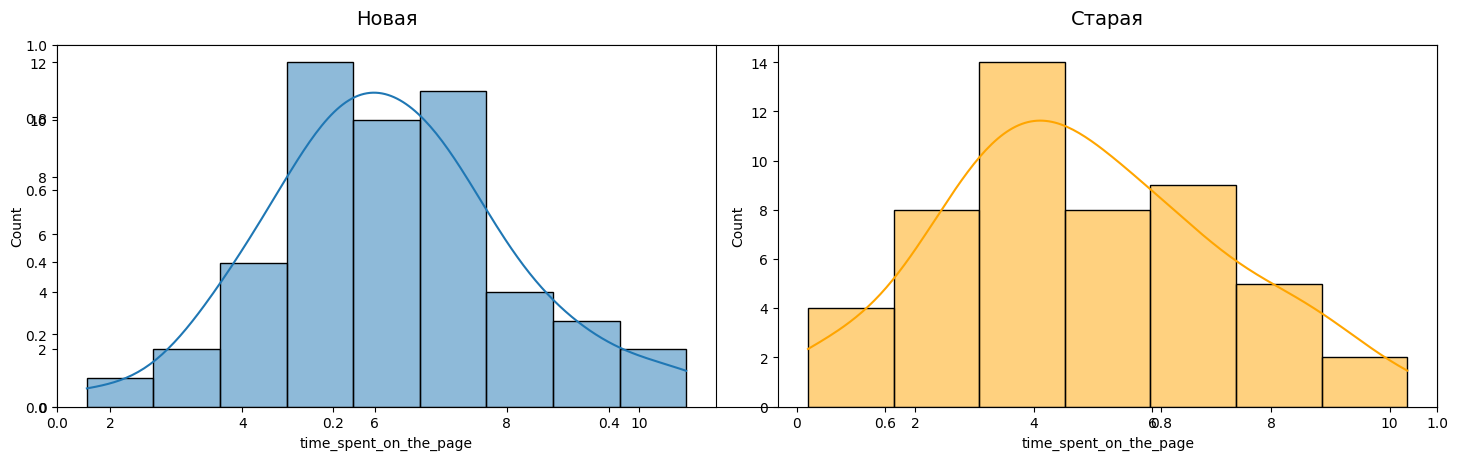

In [ ]:
#Проверка предположения о нормальности при помощи гистограммы
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df[df['landing_page'] == 'new'], x="time_spent_on_the_page", kde=True)
plt.title(label='Новая', loc='center', pad='15', fontsize="14")

plt.subplot(1, 2, 2)
sns.histplot(data=df[df['landing_page'] == 'old'], x="time_spent_on_the_page", kde=True, color='orange')
plt.title(label='Старая', loc='center', pad='15', fontsize="14")
plt.tight_layout()
plt.show()


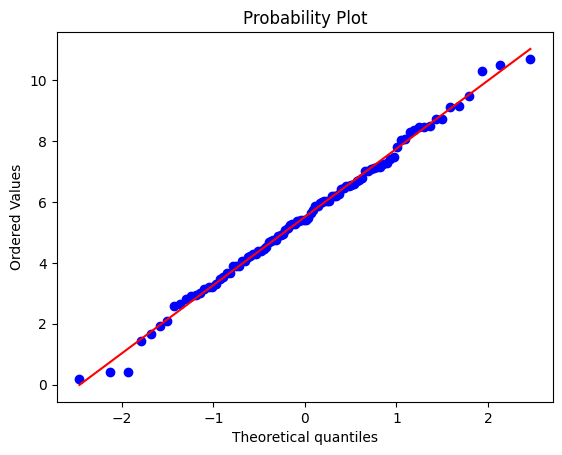

In [ ]:
#Проверка предположения о нормальности при помощи qq

stats.probplot(df['time_spent_on_the_page'], dist='norm', plot=pylab)
pylab.show()


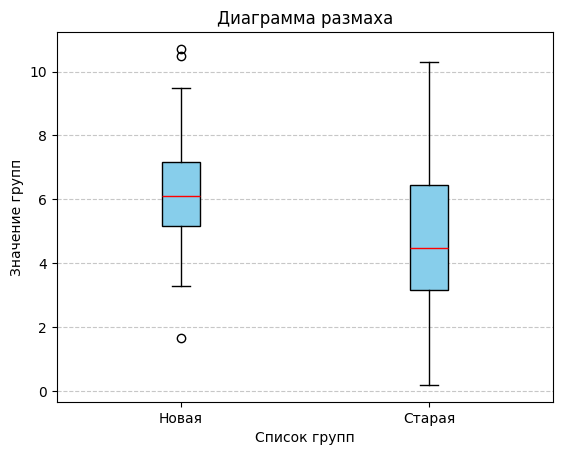

In [ ]:
#Построим диаграмму размаха
list_datasets = [df[df['landing_page'] == 'new']["time_spent_on_the_page"], df[df['landing_page'] == 'old']["time_spent_on_the_page"]]
list_labels = ("Новая", "Старая")
plt.boxplot(list_datasets,
            patch_artist=True,
            labels=list_labels,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
plt.title('Диаграмма размаха')
plt.ylabel('Значение групп')
plt.xlabel('Список групп')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
#по гистограмме мы не можем сделать точные выводы,проверим гипотезу с помощью критерия Шапиро-Уилка
test_stat, pvalue = shapiro(df['time_spent_on_the_page'])
print('Test Stat = %.4f, p-value = %.4f \n' % (test_stat, pvalue))

Test Stat = 0.9938, p-value = 0.9312 



In [ ]:
#p-значение больше 0.05, это означает, что нельзя отвергнуть нулевую гипотезу.
#Делаем вывод, что данные приходят из нормального распределения.

Однородность дисперсии

Для определения однородности отклонений будет применен критерий Левена

In [ ]:
#H0: Статистически значимой разницы между распределением выборки и теоретическим нормальным распределением нет
#H1: Существует статистически значимая разница между распределением выборки и теоретическим нормальным распределением

In [ ]:
ttest_lev, p_value_lev = levene(df[df['landing_page'] == 'new']['time_spent_on_the_page'], df[df['landing_page'] == 'old']['time_spent_on_the_page'])
print ("ttest statistics: {}\np_value: {}\n".format(ttest_lev, p_value_lev))

ttest statistics: 3.149865707124098
p_value: 0.07903822248145773



In [ ]:
#значение p_value больше 0,05, значит мы не можем отклонить H0. Предположение о гомогенности дисперсий подтвердилось.

Реализация гипотезы

In [ ]:
#Мы доказали нормальность распределения значений и однородность дисперсии.
#Данные независимы, стандартное отклонение неизвестно, а выборки больше 30, поэтому будет применен independent two-sample T-Test

Independent Two-Sample T-Test

In [ ]:
#гипотезы
#H0: новый дизайн никак не повлиял на продолжительность просмотра на сайте

#H1: новый дизайн увеличил продолжительность просмотра на сайте

In [ ]:
#сформируем подвыборку для новой и старой страницы
time_spent_new = df[df['landing_page'] == 'new']['time_spent_on_the_page']

time_spent_old = df[df['landing_page'] == 'old']['time_spent_on_the_page']

In [ ]:
#посчитаем p-value
test_stat, p_value = ttest_ind(time_spent_new, time_spent_old, equal_var=False, alternative = 'greater')
print('P-value', p_value)

P-value 0.0004944834639251083


In [ ]:
#сравним p_value c alpha
if p_value < 0.05:
    print(f'Так как p-value {p_value} меньше уровня значимости, мы отклоняем нулевую гипотезу')
else:
    print(f'Так как p-value {p_value} больше уровня значимости, мы не можем отклонить нулевую гипотезу.')

Так как p-value 0.0004944834639251083 меньше уровня значимости, мы отклоняем нулевую гипотезу


In [ ]:
#Мы видим, что значение p меньше альфа, нулевая гипотеза отвергается.
#Следовательно, у нас достаточно статистических данных, чтобы сказать, что пользователи проводят на новой странице больше времени, чем на старой странице


In [ ]:
#вычислим на сколько % увеличилось время просмотра страницы
new_time = df[df['landing_page'] == 'new']['time_spent_on_the_page'].mean()
old_time = df[df['landing_page'] == 'old']['time_spent_on_the_page'].mean()

#Время просмотра страницы увеличилось на 1.3%
print(f'Время просмотра страницы увеличилось на {round(new_time/old_time, 2)}%')

Время просмотра страницы увеличилось на 1.3%


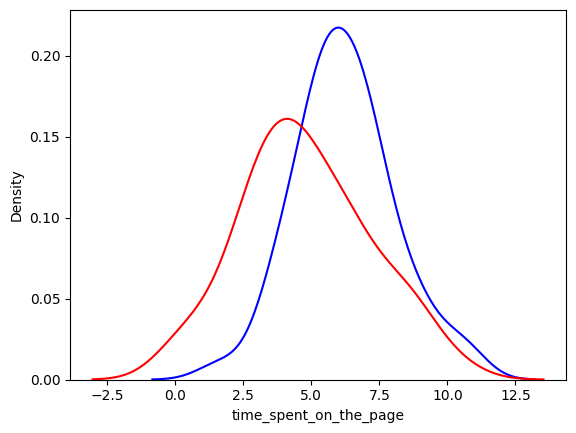

In [ ]:
#построим график для нагллядного сравнения разницы
sns.kdeplot(df[df['landing_page'] == 'new']['time_spent_on_the_page'], color='blue')
sns.kdeplot(df[df['landing_page'] == 'old']['time_spent_on_the_page'], color='red')
plt.show()